# Demand Mapping for EVCS Location and Capacity Optimization

In this analysis, we aim to map the demand for Electric Vehicle Charging Stations (EVCS) using Origin-Destination (OD) data and Points of Interest (POI) data. Here's the approach:

- **OD Data**: The OD data is provided at the Census Block Group level.
- **POI Data**: We are working with approximately 380,000 POI points, each representing potential demand sites.
- **Demand Definition**: Demand is defined as potential EV users, with the `Destination` data from car trips serving as a proxy for demand in each Census Block Group.
  
To appropriately distribute the demand spatially, the following steps are taken:
1. For each Census Block Group, the `Destination` value is divided among the corresponding POI points within that group. If a Census Block Group has a destination value `d` and contains `n` POI points, then each POI is assigned a demand value of `d/n`.
2. Next, we define a 500m resolution grid across the entire state of Georgia. For each grid cell, we sum the demand values of all POI points located within that grid cell.
3. Once the demand values are computed for each grid cell, we scale the demand map to a range between 0 and 1000. This ensures that the demand values are normalized for further analysis and visualization.

The reason for assigning the `Destination` values evenly across the POI is that each POI represents individual establishments within larger buildings, such as stores within shopping malls or department stores (e.g., hair salons, restaurants, cafes, etc.), rather than the entire building itself. Typically, locations with higher demand tend to have more POI points, which naturally reflects the distribution of demand. Therefore, we believe that uniformly assigning demand across the POI provides a more accurate and natural mapping approach.

This process will provide us with a high-resolution, normalized demand map, which will serve as input for the optimization model to determine optimal EVCS locations and capacities.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

#### 1. Census Block Group Polygon

/tmp/ipykernel_3212679/3199126699.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


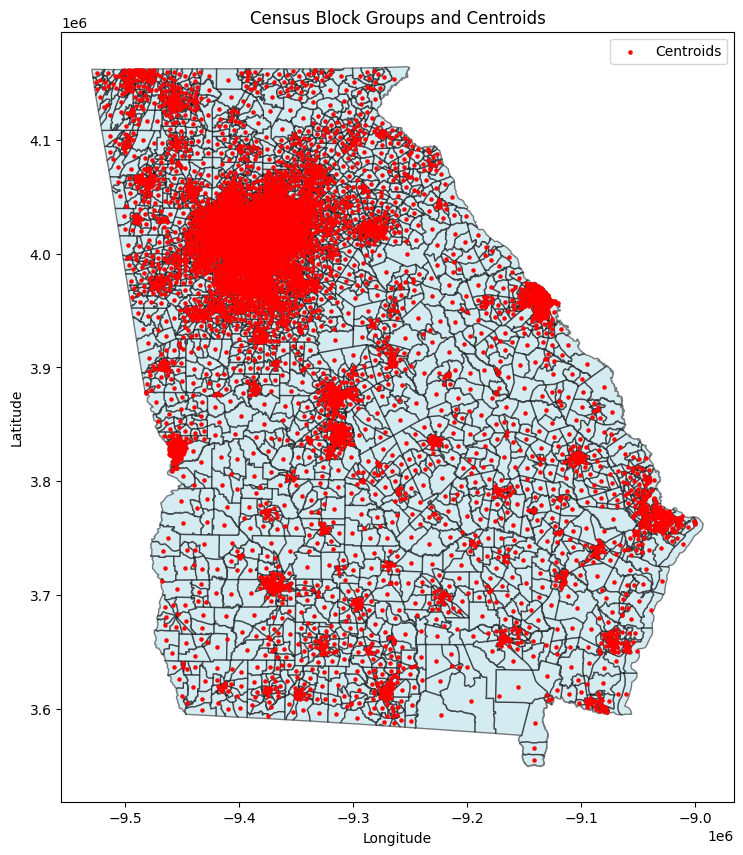

In [5]:
# 1. Load Census Block Group data

# TODO: Path to the Census Block Group polygon shapefile (e.g., "/path/to/census_block_group.shp")
census_shp_path = None

census_gdf = gpd.read_file(census_shp_path)
census_gdf = census_gdf.to_crs('EPSG:3857')

# 2. Calculate the centroid for each block group
census_gdf['GEOID'] = census_gdf['GEOID'].astype(str)
census_gdf['centroid'] = census_gdf.geometry.centroid
centroid_dict = census_gdf.set_index('GEOID')['centroid'].to_dict()

# At this point:
# - 'census_gdf' contains the reprojected census block group data with a new 'centroid' column.
# - 'centroid_dict' is a dictionary mapping each 'GEOID' to its corresponding centroid.

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

census_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Census Block Groups')
census_gdf['centroid'].plot(ax=ax, color='red', marker='o', markersize=5, label='Centroids', linestyle='None')

ax.set_title('Census Block Groups and Centroids')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()

#### 2. Spatial join OD data with Census Block Group

In [14]:
# TODO: Path to the Origin-Destination (OD) data CSV file
od_data_path = None
od_df = pd.read_csv(od_data_path)

# Convert IDs to string and map centroids to origin and destination zones
od_df[['origin_zone_id', 'destination_zone_id']] = od_df[['origin_zone_id', 'destination_zone_id']].astype(str)
od_df['origin_geometry'] = od_df['origin_zone_id'].map(centroid_dict)
od_df['destination_geometry'] = od_df['destination_zone_id'].map(centroid_dict)
od_df.dropna(subset=['origin_geometry', 'destination_geometry'], inplace=True)

od_df.head()

/tmp/ipykernel_3197446/1193228977.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  od_df = pd.read_csv(od_data_path)


,year,month,origin_zone_id,destination_zone_id,origin_zone_name,destination_zone_name,origin_state,destination_state,origin_flag,destination_flag,...,income_0_25k_pct,income_25_50k_pct,income_50_75k_pct,income_75_125k_pct,income_gt125k_pct,gender_male_pct,gender_female_pct,flag,origin_geometry,destination_geometry
20583,2019,9,130019501001,130019501001,Block Group 1,Block Group 1,GA,GA,gdot_core,gdot_core,...,0.402607,0.228934,0.211656,0.109572,0.047230,0.5,0.5,0,POINT (-9170415.117483318 3750254.2575355656),POINT (-9170415.117483318 3750254.2575355656)
20584,2019,9,130019501001,130019501001,Block Group 1,Block Group 1,GA,GA,gdot_core,gdot_core,...,0.586282,0.096498,0.200292,0.090843,0.026085,0.5,0.5,0,POINT (-9170415.117483318 3750254.2575355656),POINT (-9170415.117483318 3750254.2575355656)
20585,2019,9,130019501001,130019501002,Block Group 1,Block Group 2,GA,GA,gdot_core,gdot_core,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.5,0.5,0,POINT (-9170415.117483318 3750254.2575355656),POINT (-9145610.448201189 3743529.2620775998)
20586,2019,9,130019501001,130019501002,Block Group 1,Block Group 2,GA,GA,gdot_core,gdot_core,...,0.000000,0.000000,0.106259,0.735080,0.158661,0.5,0.5,0,POINT (-9170415.117483318 3750254.2575355656),POINT (-9145610.448201189 3743529.2620775998)
20587,2019,9,130019501001,130019501003,Block Group 1,Block Group 3,GA,GA,gdot_core,gdot_core,...,0.418335,0.233930,0.268440,0.070337,0.008957,0.5,0.5,0,POINT (-9170415.117483318 3750254.2575355656),POINT (-9159070.600191433 3748380.484837845)


#### 3. Calculate Car Trips per POI

In [ ]:
# TODO: Path to the Point of Interest (POI) data file
poi_shp_path = None
poi_gdf = gpd.read_file(poi_shp_path)
poi_gdf = poi_gdf.to_crs('EPSG:3857')

# 5. Perform spatial join between POI data and Census Block Group data
# Calculate the number of POIs per Census Block Group and sum OD data by block group
poi_with_group = gpd.sjoin(poi_gdf, census_gdf[['GEOID', 'geometry']], how='left', predicate='within')
poi_count_by_group = poi_with_group.groupby('GEOID').size().reset_index(name='poi_count')
od_grouped = od_df.groupby('origin_zone_id')['mode_car'].sum().reset_index()

poi_with_group = poi_with_group.merge(poi_count_by_group, on='GEOID', how='left')
poi_with_group = poi_with_group.merge(od_grouped, left_on='GEOID', right_on='origin_zone_id', how='left')

# Calculate the number of car trips per POI
poi_with_group['mode_car_per_poi'] = poi_with_group['mode_car'] / poi_with_group['poi_count']

#### 4. Generate Demand Map

In [18]:
# 1. Generate a grid based on Census Block Group bounding box
xmin, ymin, xmax, ymax = census_gdf.total_bounds
grid_resolution = 500
x_coords = np.arange(xmin, xmax + grid_resolution, grid_resolution)
y_coords = np.arange(ymin, ymax + grid_resolution, grid_resolution)

grid_polygons = [box(x, y, x + grid_resolution, y + grid_resolution) for x in x_coords[:-1] for y in y_coords[:-1]]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_polygons}, crs='EPSG:3857')
grid_gdf['grid_id'] = grid_gdf.index

# 2. Spatial join to map POI data to the grid and aggregate car trips per POI
poi_with_group = poi_with_group.drop(columns=['index_left', 'index_right'], errors='ignore')
poi_with_grid = gpd.sjoin(poi_with_group, grid_gdf[['grid_id', 'geometry']], how='left', predicate='within')

# Aggregate car trips per grid cell
grid_sum = poi_with_grid.groupby('grid_id')['mode_car_per_poi'].sum().reset_index()
grid_gdf = grid_gdf.merge(grid_sum, on='grid_id', how='left').fillna(0)

# 3. Save the unscaled data as a GeoTIFF file (original values)
minx, miny, maxx, maxy = grid_gdf.total_bounds
width = int((maxx - minx) / grid_resolution)
height = int((maxy - miny) / grid_resolution)
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Use the original values for rasterization
shapes = ((geom, value) for geom, value in zip(grid_gdf.geometry, grid_gdf['mode_car_per_poi']))
raster = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='float32')

# 4. Perform Min-Max Scaling (between 0 and 1000) on the original raster
min_val = np.min(raster[raster > 0])
max_val = np.max(raster)

# Scale the data
scaled_raster = (raster - min_val) / (max_val - min_val) * 1000
scaled_raster[raster == 0] = 0  # Ensure that zero values remain unchanged

# TODO: Path to save the scaled demand data as a GeoTIFF file
scaled_tif_path = None
with rasterio.open(scaled_tif_path, 'w', driver='GTiff', height=height, width=width, count=1, dtype='float32', crs='EPSG:3857', transform=transform) as dst:
    dst.write(scaled_raster, 1)

print(f"Scaled GeoTIFF saved to {scaled_tif_path}")

Scaled GeoTIFF saved to demand_map_500.tif


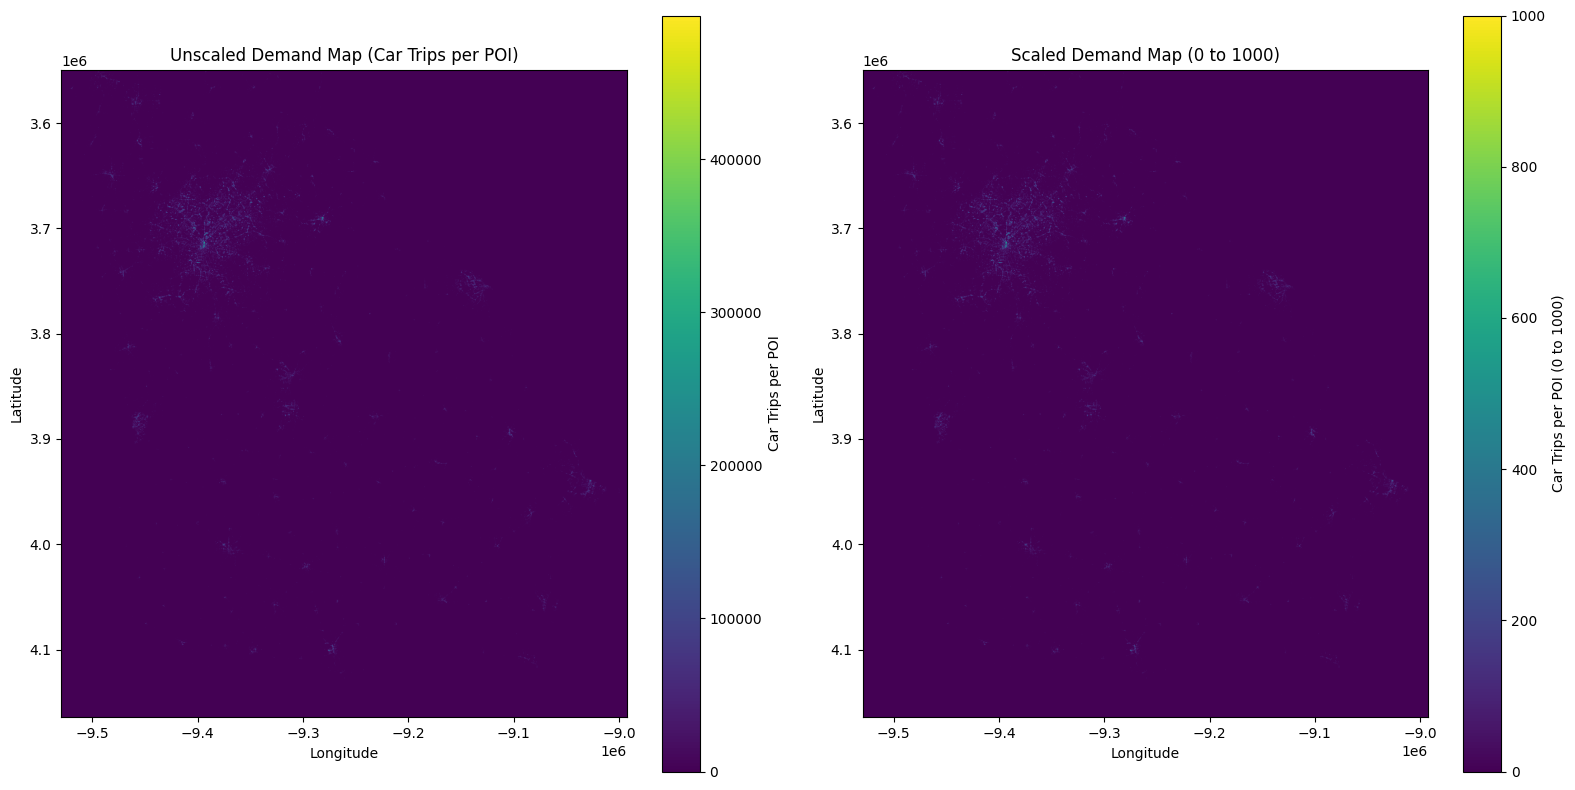

In [19]:
# Visualization
# 1. Create extent from the transform and raster dimensions
minx, miny = transform * (0, 0)
maxx, maxy = transform * (width, height)
extent = [minx, maxx, miny, maxy]  # Define the extent for the plot

# 2. Create subplots for before and after scaling
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the unscaled raster (before scaling)
im1 = axs[0].imshow(raster, cmap='viridis', extent=extent)
axs[0].set_title('Unscaled Demand Map (Car Trips per POI)')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].grid(False)
fig.colorbar(im1, ax=axs[0], label='Car Trips per POI')

# Plot the scaled raster (after scaling)
im2 = axs[1].imshow(scaled_raster, cmap='viridis', extent=extent)
axs[1].set_title('Scaled Demand Map (0 to 1000)')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].grid(False)
fig.colorbar(im2, ax=axs[1], label='Car Trips per POI (0 to 1000)')

# Show the plots
plt.tight_layout()
plt.show()